In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
import numpy as np 
import torchvision

In [51]:
batch_size = 64

!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST
from torchvision import transforms

train_set = MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=True)


test_set = MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=False)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2, drop_last=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2, drop_last=True)

--2021-11-01 21:51:35--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-11-01 21:51:35--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [       <=>          ]  33.20M  4.79MB/s    in 5.5s    

2021-11-01 21:51:41 (5.99 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [42]:
class Discriminator(nn.Module):
    def __init__(self, image_nc):
        super(Discriminator, self).__init__()
        model = [
            nn.Conv2d(image_nc, 8, kernel_size=4, stride=1, padding=0, bias=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 1, 2),
            nn.Sigmoid()
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        output = self.model(x).squeeze()
        return output

In [4]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type='reflect', norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [12]:
class Generator(nn.Module):
    def __init__(self,
                 gen_input_nc,
                 image_nc,
                 ):
        super(Generator, self).__init__()

        encoder_lis = [
            nn.Conv2d(gen_input_nc, 8, kernel_size=3, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
        ]

        bottle_neck_lis = [ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),]

        decoder_lis = [
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, image_nc, kernel_size=6, stride=1, padding=0, bias=False),
            nn.Tanh(),
        ]
        self.linear = nn.Linear(32*5*5+10, 32*5*5)
        self.encoder = nn.Sequential(*encoder_lis)
        self.bottle_neck = nn.Sequential(*bottle_neck_lis)
        self.decoder = nn.Sequential(*decoder_lis)

    def forward(self, x, gen_labels):
        x = self.encoder(x)
        one_hot = F.one_hot(gen_labels, 10)
        x = self.linear(torch.cat((x.view(-1, 32*5*5), one_hot), 1)).view(-1, 32, 5,5)
        x = self.bottle_neck(x)
        x = self.decoder(x)
        return x

In [13]:
gen = Generator(3,3).cuda()
x = torch.randn((64,3,28,28)).cuda()
gen_labels = torch.randint(0,10, (x.shape[0],)).cuda()
gen(x,gen_labels).shape

torch.Size([64, 3, 28, 28])

In [34]:
class ModelA(nn.Module):
    def __init__(self):
        super(ModelA, self).__init__()
        model = [
            nn.Conv2d(1, 64, kernel_size=5, stride=5, padding=0, bias=True),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=5, stride=5, padding=0, bias=True), nn.ReLU(),
            nn.Dropout(0.25),
            nn.Flatten(start_dim=1),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0,5),
            nn.Linear(128,10)
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        output = self.model(x)
        return output


In [28]:
classifier = ModelA()
x = torch.randn((64,1,28,28))
classifier(x).shape

torch.Size([64, 10])

In [78]:
classifier = ModelA().cuda()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()
for epoch in range(10):
  for i, (x,y) in enumerate(train_loader):
    x, y = x.cuda(), y.cuda()
    optimizer.zero_grad()
    train_loss = loss(classifier(x), y)
    train_loss.backward()
    optimizer.step()
    if (i%100 == 0):
        print('Epoch [{}/{}], Step [{}/{}], Classifier_loss: {}'.format(epoch+1, 20, i+1, len(train_loader), train_loss.item()))

Epoch [1/20], Step [1/937], Classifier_loss: 2.2999038696289062
Epoch [1/20], Step [101/937], Classifier_loss: 0.5592408180236816
Epoch [1/20], Step [201/937], Classifier_loss: 0.5077797174453735
Epoch [1/20], Step [301/937], Classifier_loss: 0.5867003202438354
Epoch [1/20], Step [401/937], Classifier_loss: 0.3286798298358917
Epoch [1/20], Step [501/937], Classifier_loss: 0.45363500714302063
Epoch [1/20], Step [601/937], Classifier_loss: 0.16007553040981293
Epoch [1/20], Step [701/937], Classifier_loss: 0.33962342143058777
Epoch [1/20], Step [801/937], Classifier_loss: 0.15353228151798248
Epoch [1/20], Step [901/937], Classifier_loss: 0.28640392422676086
Epoch [2/20], Step [1/937], Classifier_loss: 0.14294371008872986
Epoch [2/20], Step [101/937], Classifier_loss: 0.31585800647735596
Epoch [2/20], Step [201/937], Classifier_loss: 0.14805378019809723
Epoch [2/20], Step [301/937], Classifier_loss: 0.12771347165107727
Epoch [2/20], Step [401/937], Classifier_loss: 0.12041027843952179
Epoc

In [79]:
def accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy: %s %%' % (100 * correct / total))

In [80]:
accuracy(classifier)

Accuracy: 97.33573717948718 %


In [92]:
epochs = 10
lr = 1e-3
G = Generator(1,1).cuda()
D = Discriminator(1).cuda()
Goptimizer = torch.optim.Adam(G.parameters(), lr=lr)
Doptimizer = torch.optim.Adam(D.parameters(), lr=lr)
CELoss = nn.CrossEntropyLoss()
for epoch in range(epochs):
  for i,(x,y) in enumerate(train_loader):
    x,y = x.cuda(), y.cuda()

    labels = torch.randint(0,10, (x.shape[0],)).cuda()
    perturbations = G(x, gen_labels)
    adv_images = perturbations + x
    adv_images = torch.clamp(adv_images, 0, 1)

    Doptimizer.zero_grad()
    pred_real = D(x)
    loss_D_real = loss_D_real = F.mse_loss(pred_real, torch.ones_like(pred_real).cuda())
    loss_D_real.backward()

    pred_fake = D(adv_images.detach())
    loss_D_fake = F.mse_loss(pred_fake, torch.zeros_like(pred_fake).cuda())
    loss_D_fake.backward()
    Doptimizer.step()

    Goptimizer.zero_grad()
    pred_fake = D(adv_images)
    loss_G_fake = F.mse_loss(pred_fake, torch.ones_like(pred_fake).cuda())
    loss_G_fake.backward(retain_graph=True)

    # calculate perturbation norm
    C = 0.1
    loss_perturb = torch.mean(torch.norm(perturbations.view(perturbations.shape[0], -1), 2, dim=1))
    # loss_perturb = torch.max(loss_perturb - C, torch.zeros(1, device=self.device))

    # cal adv loss
    logits_model = classifier(adv_images)
    probs_model = F.softmax(logits_model, dim=1)

    # C&W loss function
    """real = torch.sum(onehot_labels * probs_model, dim=1)
    other, _ = torch.max((1 - onehot_labels) * probs_model - onehot_labels * 10000, dim=1)
    zeros = torch.zeros_like(other)
    loss_adv = torch.max(real - other, zeros)
    loss_adv = torch.sum(loss_adv)"""

    # maximize cross_entropy loss
    # loss_adv = -F.mse_loss(logits_model, onehot_labels)
    loss_adv = F.cross_entropy(logits_model, labels)

    adv_lambda = 1000
    pert_lambda = 1
    loss_G = adv_lambda * loss_adv + pert_lambda * loss_perturb
    loss_G.backward()
    Goptimizer.step()

    optimizer.step()
    if i%100==0:
      print('Epoch [{}/{}], Step [{}/{}], LossG: {}, LossD: {}, foolLoss: {}'.format(epoch+1, epochs, i+1, len(train_loader), loss_G.item(), (loss_D_fake + loss_D_real).item(), loss_adv.item()))

Epoch [1/10], Step [1/937], LossG: 2338.554931640625, LossD: 0.5155104398727417, foolLoss: 2.32260799407959
Epoch [1/10], Step [101/937], LossG: 2308.80224609375, LossD: 0.49946045875549316, foolLoss: 2.3084683418273926
Epoch [1/10], Step [201/937], LossG: 2320.7255859375, LossD: 0.5003821849822998, foolLoss: 2.3204970359802246
Epoch [1/10], Step [301/937], LossG: 2285.517333984375, LossD: 0.4980583190917969, foolLoss: 2.285327672958374
Epoch [1/10], Step [401/937], LossG: 2289.756103515625, LossD: 0.4989567995071411, foolLoss: 2.2896032333374023
Epoch [1/10], Step [501/937], LossG: 2273.8291015625, LossD: 0.49578338861465454, foolLoss: 2.2737135887145996
Epoch [1/10], Step [601/937], LossG: 2310.46435546875, LossD: 0.4726802706718445, foolLoss: 2.310265302658081
Epoch [1/10], Step [701/937], LossG: 2320.90771484375, LossD: 0.5111532807350159, foolLoss: 2.3206827640533447
Epoch [1/10], Step [801/937], LossG: 2318.18798828125, LossD: 0.45519036054611206, foolLoss: 2.317981004714966
Epoc

KeyboardInterrupt: ignored

In [55]:
def adv_accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          gen_labels = torch.randint(0,10, (x.shape[0],)).cuda()
          perturbation = G(images, gen_labels)
          outputs = net(torch.clamp(images + perturbation, 0, 1))
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Adversarial accuracy: %s %%' % (100 * correct / total))

In [56]:
adv_accuracy(classifier)

Adversarial accuracy: 9.575320512820513 %


tensor(0.0196, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([[3.8609e-13, 4.2902e-08, 7.6958e-09, 7.4482e-08, 3.7235e-10, 6.1206e-11,
         5.3104e-18, 1.0000e+00, 4.1863e-11, 1.7970e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


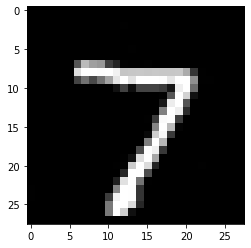

In [88]:
for i,(x,y) in enumerate(test_loader):
  if i > 0: break
  x,y = x.cuda(), y.cuda()
  gen_labels = torch.randint(0,10, (x.shape[0],)).cuda()
  perturb = G(x, gen_labels)
  adv_image = torch.clamp(x+perturb, 0, 1)
  print(torch.max(perturb))
  plt.imshow(adv_image[0].squeeze(2).cpu().detach().numpy().squeeze(0), cmap='gray')
  print(F.softmax(classifier(adv_image[0].unsqueeze(0)), 1))

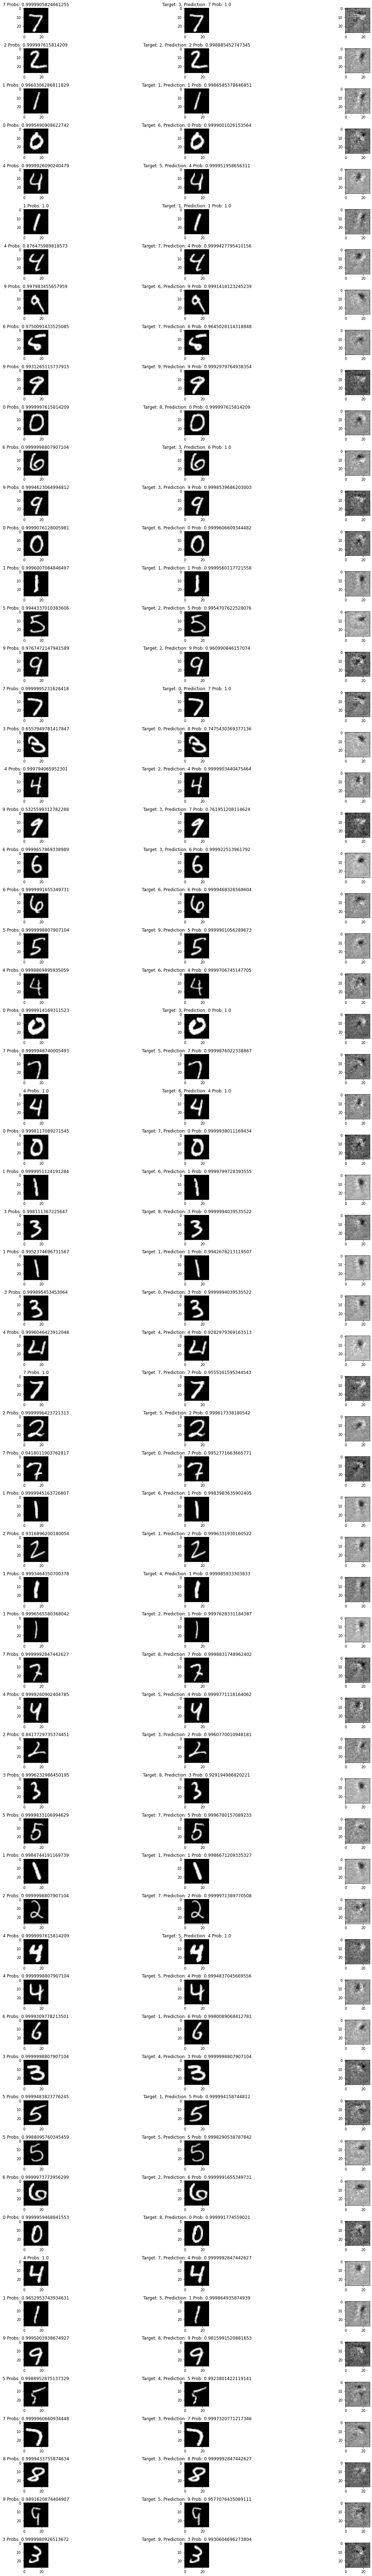

In [85]:
for x,y in test_loader:
  gen_labels = torch.randint(0,10, (x.shape[0],)).cuda()
  x,y = x.cuda(), y.cuda()
  base_predictions = F.softmax(classifier(x), 1)
  perturbations = G(x, gen_labels)
  new_predictions = F.softmax(classifier(torch.clamp(x+perturbations, 0, 1)), 1)
  fig, axs = plt.subplots(64, 3)
  fig.set_figheight(100)
  fig.set_figwidth(20)
  images = []
  for i in range(64):
          image, perturbation = x[i].detach().cpu().numpy().transpose(1,2,0), perturbations[i].detach().cpu().numpy().transpose(1,2,0)
          image = image.squeeze(2)
          perturbation = perturbation.squeeze(2)
          images.append(axs[i, 0].imshow(image, cmap='gray'))
          axs[i,0].title.set_text(f'{torch.argmax(base_predictions[i]).item()} Probs: {torch.max(base_predictions[i]).item()}')
          images.append(axs[i,1].imshow(np.clip(image+perturbation,0,1), cmap='gray'))
          axs[i,1].title.set_text(f'Target: {gen_labels[i]}, Prediction: {torch.argmax(new_predictions[i]).item()} Prob: {torch.max(new_predictions[i]).item()}')
          images.append(axs[i,2].imshow(perturbation, cmap='gray'))
  break

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


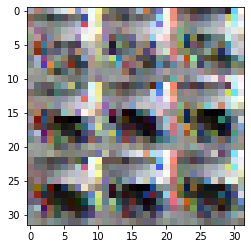

In [ ]:
result = model(torch.randn((1,3072)).cuda(), rev=True)
plt.imshow(result.view(32,32,-1).cpu().numpy())